In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

Here, you can find some of the functions that can be called to operate on DataFrames:

1) openfiles(filename_list)
2) dataframe_info(df)
3) arrange_frame(df)
4) select_numeric(df)

In [85]:
def openfiles(filename_list):
    file1 = filename_list[0]
    file2 = filename_list[1]
    df_demand = pd.read_csv(file1)
    df_weather = pd.read_csv(file2)
    df_weather['Demand'] = df_demand['Demand (MW)']
    unwanted_cols = ['Name', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
        'Unnamed: 24', 'Unnamed: 25']
    df_overall =df_weather.drop(columns=unwanted_cols)
    return df_overall

def dataframe_info(df):
    print ('Data frame shape::', df.shape)
    print ('Data types in the DF::::  ')
    print(df.dtypes)
    print('Null values::::  ')
    print (df.isnull().sum())
    print ('Dataframe Describe::: ')
    print (df.describe())

def convert_string_to_numeric(df_overall, null_values = None):
    conditions_mapping_dict = {'Overcast':1, 'Partially cloudy' :2,'Clear':3, 'Rain, Overcast':4,
    'Rain, Partially cloudy' :5, 'Snow, Rain, Overcast':6,
    'Snow, Rain, Partially cloudy':7, 'Rain':8, 'Snow, Overcast':9,
    'Freezing Drizzle/Freezing Rain, Overcast':10, 'Ice, Overcast':11,
    'Snow, Freezing Drizzle/Freezing Rain, Ice, Overcast':12,
    'Freezing Drizzle/Freezing Rain, Ice, Overcast':13, 'Snow, Partially cloudy':14}
    df_overall['conditions'] = df_overall['conditions'].map(conditions_mapping_dict)
    month_list = []
    day_list = []
    year_list=[]
    hour_list = []
    for i in range(len(df_overall)):
        month_list.append(int(df_overall['datetime'][i].split('/')[0]))
        day_list.append(int(df_overall['datetime'][i].split('/')[1]))
        year_list.append(int(df_overall['datetime'][i].split('/')[2][:4]))
        hour_list.append(int(df_overall['datetime'][i].split(' ')[-1].split(':')[0]))
    hours = np.array(hour_list).reshape(-1,1)
    months = np.array(month_list).reshape(-1,1)
    days = np.array(day_list).reshape(-1,1)
    years = np.array(year_list).reshape(-1,1)
    df_overall['Month'] = months
    df_overall['Day'] = days
    df_overall['Year'] = years
    df_overall['Hour'] = hours
    if null_values != None:
            columns_to_drop = df_overall.columns[df_overall.isnull().sum() > null_values]
            df_overall = df_overall.drop(columns=columns_to_drop)
    df_numeric = df_overall.select_dtypes(include=['float64', 'int64', 'int32'])
    return df_numeric

def fill_null(df_overall):
    data_fill = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(data_fill.fit_transform(df_overall), columns=df_overall.columns)
    return df_imputed

def arrange_frame():
    return 0

def visualize_frame(df):
    df.boxplot()
    plt.xticks(rotation = 90)
    plt.show()
    df_corr = df.corr()
    sns.heatmap(df_corr, linewidths=1.0)
    plt.title(f'Heatmap of Correlations of DataFrame')
    plt.show()


def remove_outliers(df_imputed, col_name_list):
    for col_name in col_name_list:
        z_scores = zscore(df_imputed[col_name])
        outliers_high = (z_scores > 3)
        outliers_low = (z_scores < -3)
        print (f'Number of Outliers in {col_name}: ', outliers_high.sum() ,'+', outliers_low.sum(),'=', outliers_high.sum()+outliers_low.sum())
        outliers_low_list = df_imputed.loc[outliers_low, col_name].values
        outliers_high_list = df_imputed.loc[outliers_high, col_name].values
        if len(outliers_low_list !=0):
            df_imputed.loc[outliers_low, col_name] = outliers_low_list.max()
        if len(outliers_high_list !=0):
            df_imputed.loc[outliers_high, col_name] = outliers_high_list.min()
    print ('Outliers Replaced!')
    return df_imputed

    


Data frame shape:: (27720, 21)
Data types in the DF::::  
datetime             object
Temperature         float64
feelslike           float64
dewpoint            float64
humidity            float64
precipitation       float64
precipprob            int64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddirection       float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
uvindex               int64
severerisk          float64
conditions           object
Demand              float64
dtype: object
Null values::::  
datetime                0
Temperature             0
feelslike               0
dewpoint                0
humidity                0
precipitation           0
precipprob              0
preciptype          24969
snow                   18
snowdepth              18
windgust            15497
windspeed               0
winddirect

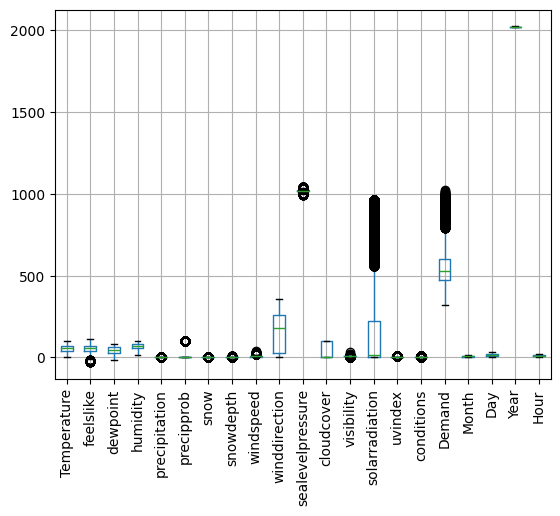

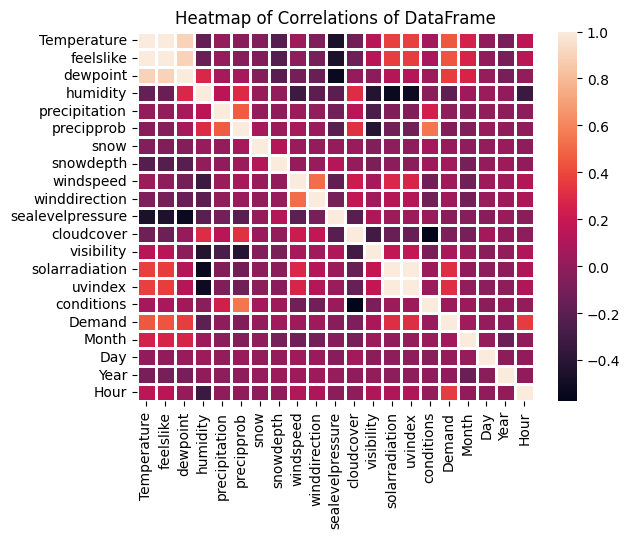

In [68]:
filenames = ['.\Data\Demand Forecasting\Demand Forecasting Demand Data upto Feb 21.csv', '.\Data\Demand Forecasting\Demand Forecasting Weather Data upto Feb 28.csv']
#Open the files
data = openfiles(filenames) 
#Info of the files
dataframe_info(data) 
#Convert possible other format features to numeric and remove features with null values greater than:
keep_if_null_is_less_than = 1000
data_numeric = convert_string_to_numeric(data, null_values=keep_if_null_is_less_than)
#Check and remove outliers if applicable
data_no_outliers = remove_outliers(data_numeric, ['Temperature', 'solarradiation', 'conditions', 'snow', 'snowdepth'])
#Remove instances with no demand (for training)
data_full_demand = data_no_outliers[pd.notna(data_no_outliers['Demand'])]
#Fill any null features of the remaining feature_list
data_final = fill_null(data_full_demand)


col_names = data_numeric.columns
print(col_names)

#Some basic plots of the initial data frame
visualize_frame(data_final)



C:\Users\Dixant\AppData\Local\Temp\ipykernel_19748\3572639994.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_final.select_dtypes(include=np.number).hist(ax=ax)


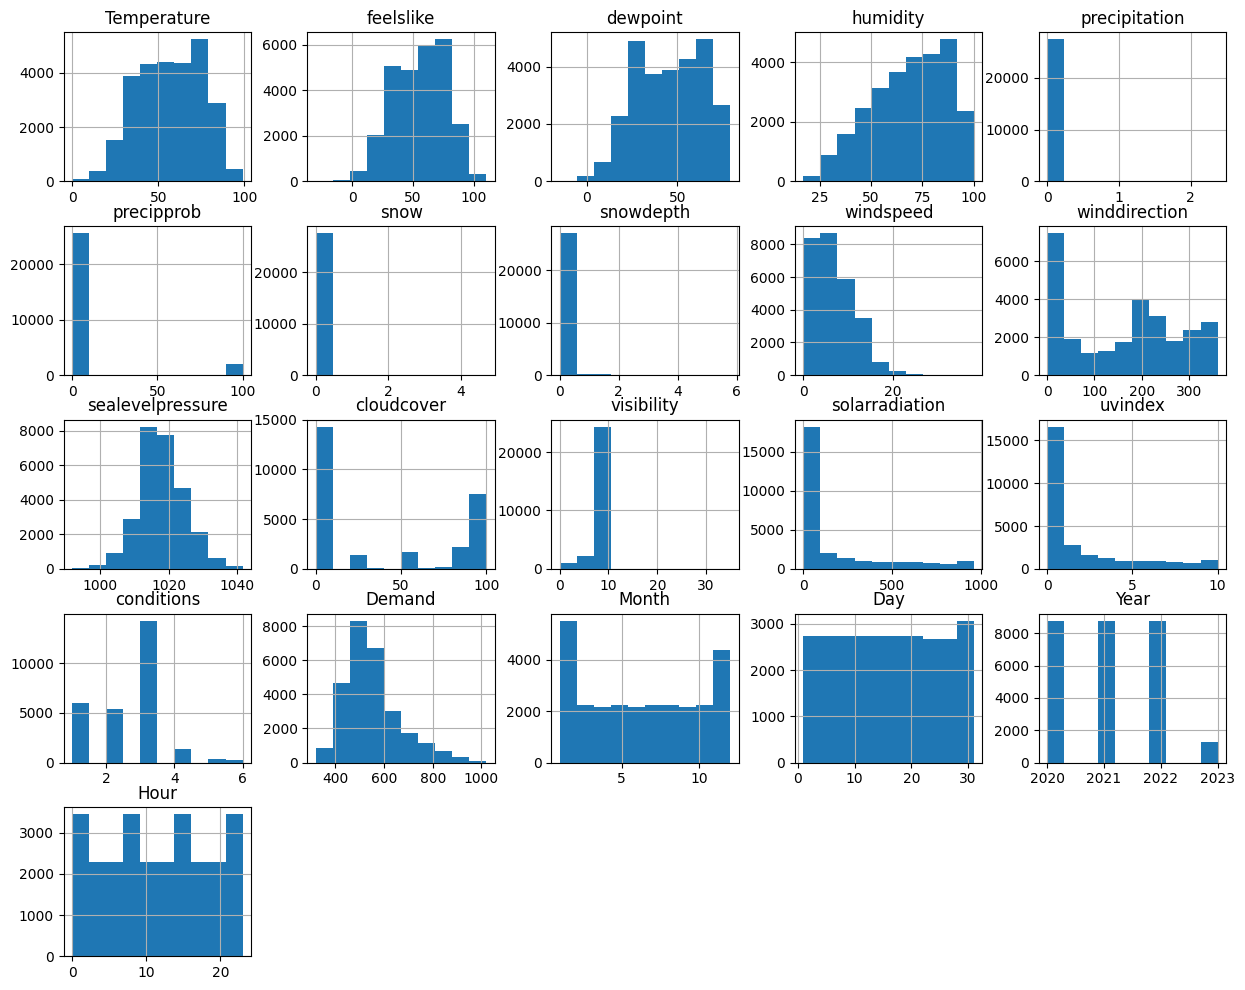

In [89]:
fig=plt.figure(figsize=(15,12))
ax=fig.gca()
data_final.select_dtypes(include=np.number).hist(ax=ax)
plt.show()

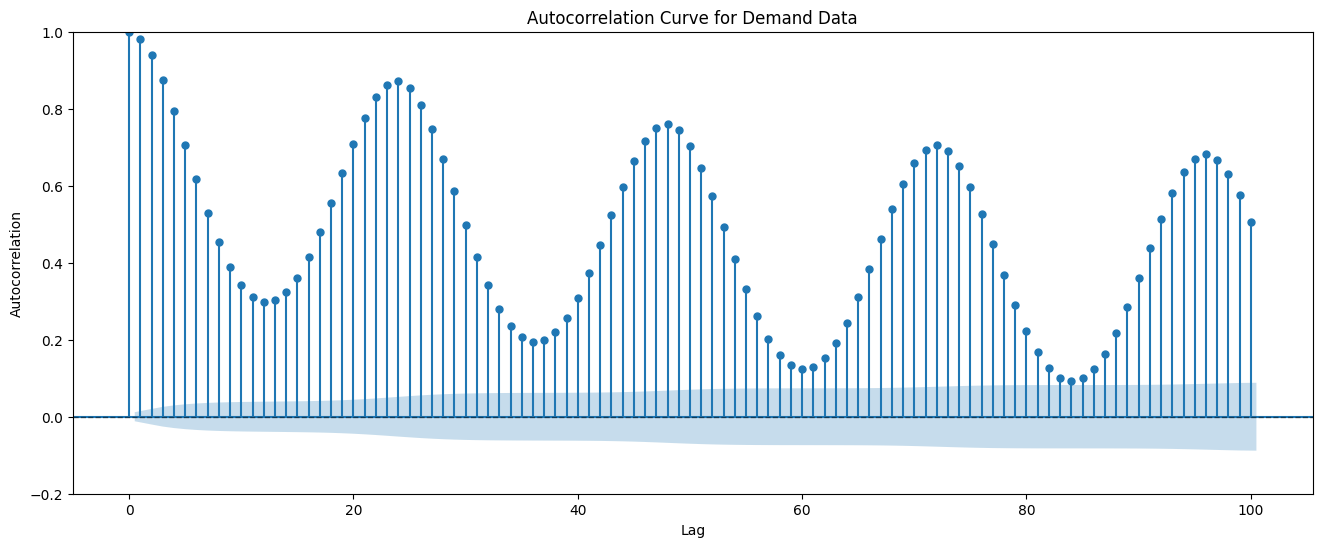

In [61]:
lag_for_acf_plot = 100
fig, ax = plt.subplots(figsize=(16, 6))

plot_acf(data_final['Demand'], lags=lag_for_acf_plot, ax=ax)

ax.axhline(0, color='black', linestyle='dashed', linewidth=1, alpha=0.5)
ax.set_ylim(bottom=-0.2)

ax.set_title('Autocorrelation Curve for Demand Data')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.show()

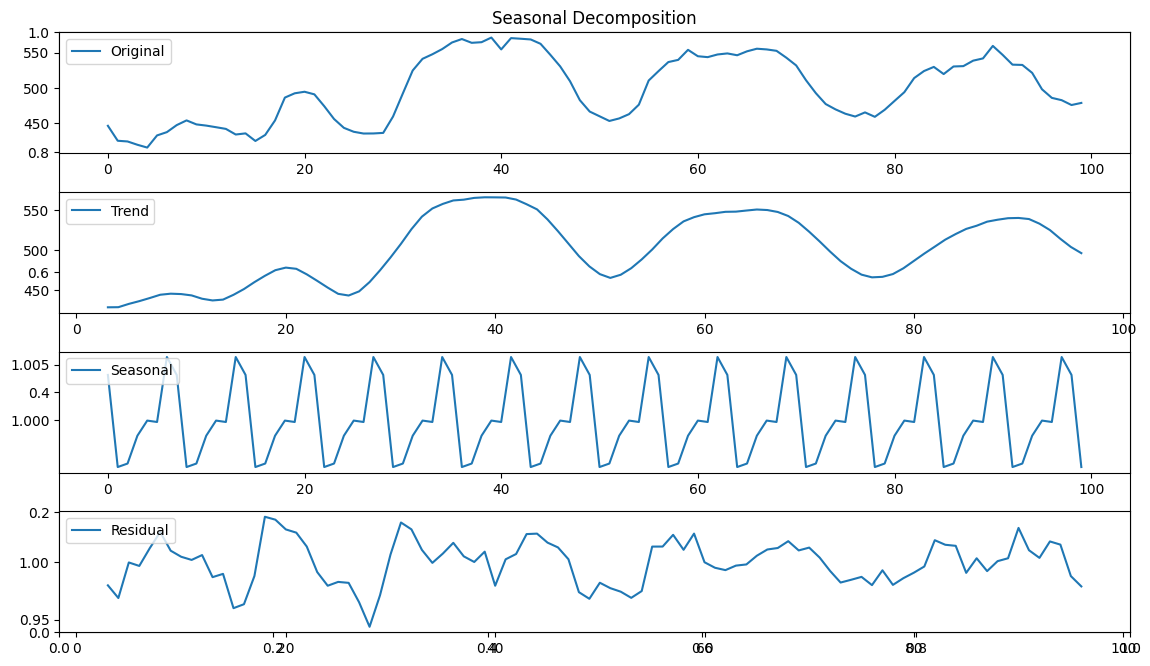

In [88]:
df_seasonal_decompose = data_final[data_final['Year'] == 2020]
result = seasonal_decompose(df_seasonal_decompose['Demand'][:100], model='multiplicative', period=7) 

# Plot the decomposed components
plt.figure(figsize=(12, 7))
plt.title('Seasonal Decomposition')
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

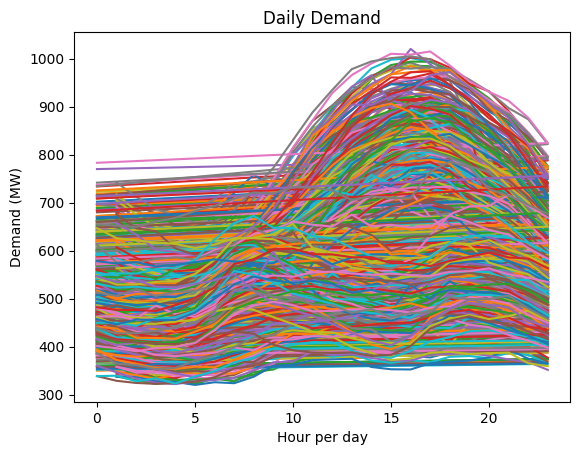

In [62]:

demand_daily = np.array(data_final['Demand']).reshape(-1, 24)
hour_daily = np.array(data_final['Hour']).reshape(-1,24)
for i in range (len(demand_daily)):
    plt.plot(hour_daily[i], demand_daily[i])
plt.title('Daily Demand')
plt.xlabel('Hour per day')
plt.ylabel('Demand (MW)')
plt.show()

Index(['Temperature', 'feelslike', 'dewpoint', 'humidity', 'precipitation',
       'precipprob', 'snow', 'snowdepth', 'windspeed', 'winddirection',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'uvindex', 'conditions', 'Demand', 'Month', 'Day', 'Year', 'Hour'],
      dtype='object')


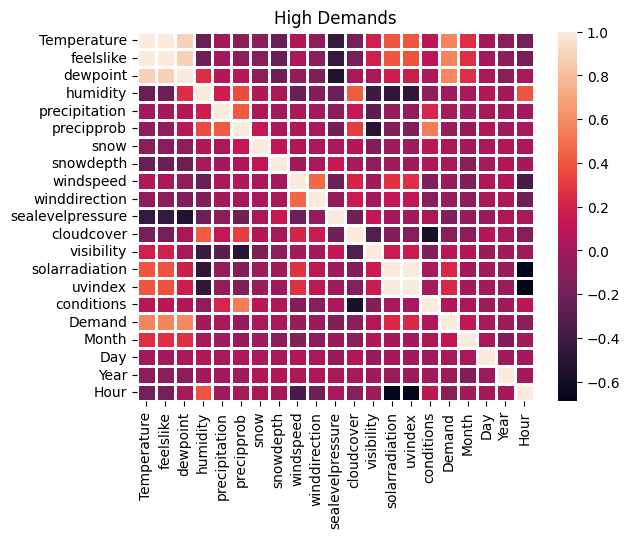

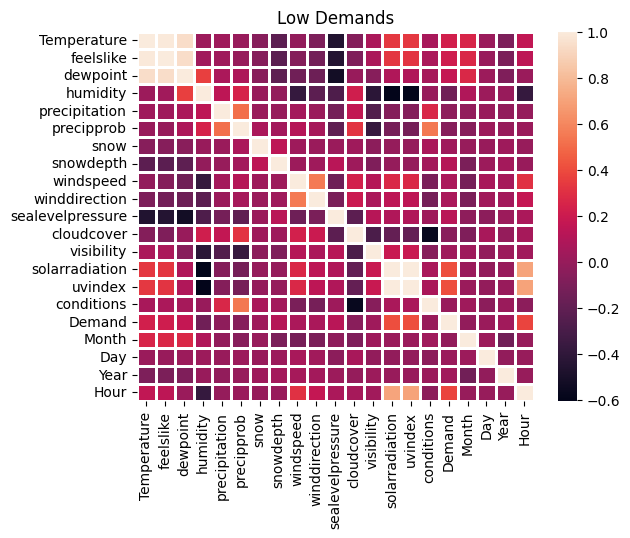

In [63]:
peak_demand_hour= 13
#print(data_final['Demand'].shape)
#print(data_final['Demand'].iloc[-1])
df_high_demand = data_final[data_final['Hour'] >= peak_demand_hour]
df_low_demand = data_final[data_final['Hour']<peak_demand_hour]
print (data_final.columns)
#print(df_high_demand['Demand'].mean(),":::::",  df_low_demand['Demand'].mean())

df_high_demand_corr = df_high_demand.corr()
df_low_demand_corr = df_low_demand.corr()
sns.heatmap(df_high_demand_corr, linewidths=1.0)
plt.title('High Demands')
plt.show()
sns.heatmap(df_low_demand_corr, linewidths=1.0)
plt.title("Low Demands")
plt.show()

In [64]:

df_high_demand = df_high_demand
df_low_demand = df_low_demand

#11 hours in high demand and 13 hours in low demand per day
peak_hours = 24 - peak_demand_hour
non_peak_hours = 24 - peak_hours
days_for_training = 1000
days_for_testing = (len(data_final['Demand'])/24)-days_for_training

#Arranging the Datasets:
df_train_set_high_demand = df_high_demand[:days_for_training*peak_hours]
df_train_set_low_demand = df_low_demand[:days_for_training*non_peak_hours]

df_test_set_high_demand = df_high_demand[days_for_training*peak_hours:]
df_test_set_low_demand = df_low_demand[days_for_training*peak_hours:]
df_high_demand.columns

Index(['Temperature', 'feelslike', 'dewpoint', 'humidity', 'precipitation',
       'precipprob', 'snow', 'snowdepth', 'windspeed', 'winddirection',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'uvindex', 'conditions', 'Demand', 'Month', 'Day', 'Year', 'Hour'],
      dtype='object')

In [70]:
estimators_for_random_forest = 200
features = ['Year', 'Month', 'Day', 'Hour','Temperature','sealevelpressure']
target = 'Demand'
df = df_high_demand 
# Extract features and target variable
X = df[features].values
y = df[target].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
high_model = RandomForestRegressor(n_estimators=200)
high_model.fit(x_train, y_train)

y_pred_high = high_model.predict(x_test).reshape(-1,1)

df = df_low_demand 
# Extract features and target variable
X = df[features].values
y = df[target].values.reshape(-1, 1)

x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(X, y, test_size=0.1)
low_model = RandomForestRegressor(n_estimators=estimators_for_random_forest)
low_model.fit(x_train_low, y_train_low)

y_pred_low = low_model.predict(x_test_low).reshape(-1,1)

c:\Users\Dixant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Dixant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[[518.2635 522.5   ]
 [563.3915 573.8   ]
 [527.6465 549.3   ]
 ...
 [539.1805 550.9   ]
 [526.678  505.7   ]
 [793.335  791.6   ]]
[[596.42   584.6   ]
 [656.2565 683.2   ]
 [489.1595 432.9   ]
 ...
 [512.461  535.3   ]
 [566.0955 598.8   ]
 [337.305  335.8   ]]


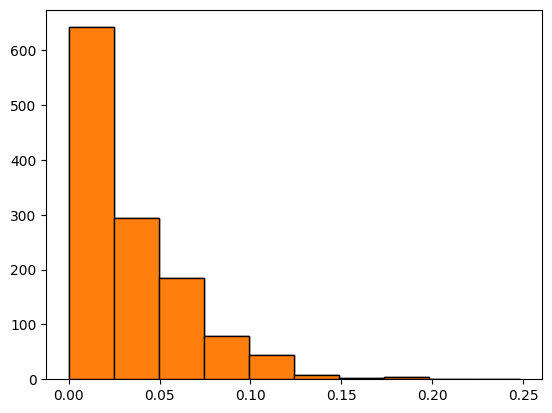

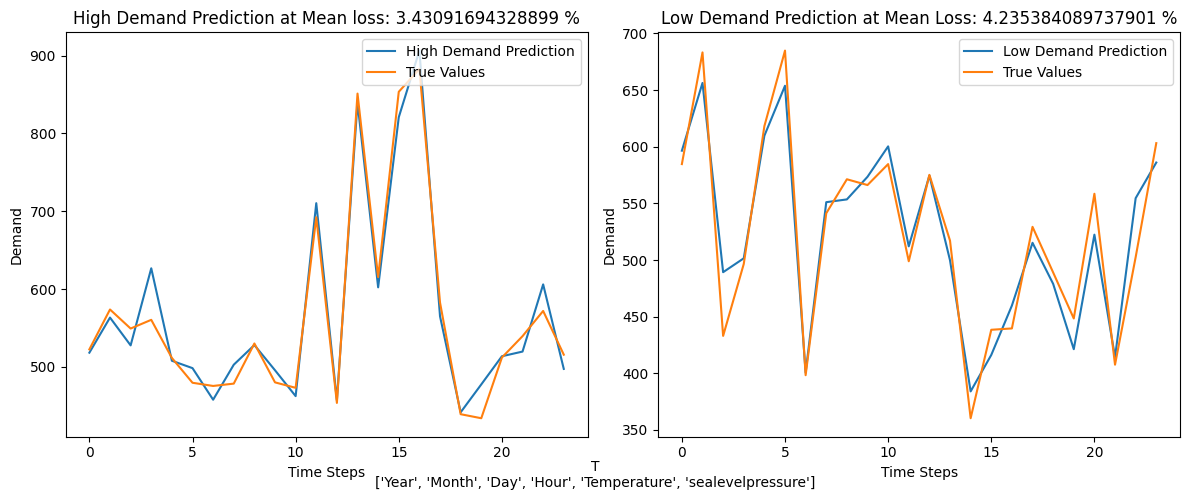

In [66]:
print(np.concatenate([y_pred_high, y_test], axis = 1))
loss = (abs(y_test-y_pred_high)/y_test)
high_loss = loss.mean()*100
plt.hist(loss, edgecolor = 'black')

print(np.concatenate([y_pred_low, y_test_low], axis = 1))
low_loss_list = (abs(y_test_low-y_pred_low)/y_test_low)
low_loss = low_loss_list.mean()*100
plt.hist(loss, edgecolor = 'black')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed
axes = ax.ravel()

# Plot for High Demand Prediction
axes[0].plot(y_pred_high[:24], label='High Demand Prediction')
axes[0].plot(y_test[:24], label='True Values')
axes[0].set_title(f'High Demand Prediction at Mean loss: {high_loss} %')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Demand')
axes[0].legend(loc = 'upper right')

# Plot for Low Demand Prediction
axes[1].plot(y_pred_low[:24], label='Low Demand Prediction')
axes[1].plot(y_test_low[:24], label='True Values')
axes[1].set_title(f'Low Demand Prediction at Mean Loss: {low_loss} %')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Demand')
axes[1].legend(loc = 'upper right')

# Share the x-axis label
fig.text(0.5, 0.04, f'T\n{features}', ha='center', va='center')
plt.tight_layout()
plt.show()

(77, 21)
(77, 6)
(77,) (91,)


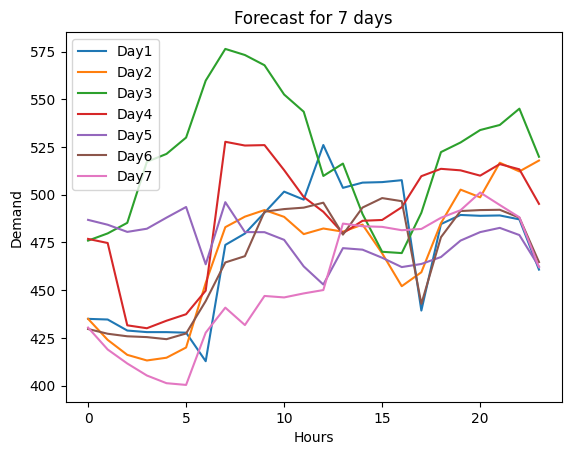

            0
0    434.9235
1    434.5890
2    428.8060
3    427.9865
4    427.9760
..        ...
163  491.8635
164  501.1425
165  494.6025
166  488.1540
167  462.0925

[168 rows x 1 columns]


In [73]:
df_testing = data_no_outliers[data_no_outliers['Demand'].isna()]

peak_after = 13
df_testing_high_demand = df_testing[df_testing['Hour'] >= peak_after]
df_testing_low_demand = df_testing[df_testing['Hour']<peak_after]

print (df_testing_high_demand.shape)
X_high_test = df_testing_high_demand[features].values
X_low_test = df_testing_low_demand[features].values

print(X_high_test.shape)

y_pred_test_high = high_model.predict(X_high_test)
y_pred_test_low = low_model.predict(X_low_test)
print (y_pred_test_high.shape, y_pred_test_low.shape)
test_output = np.concatenate([y_pred_test_low.reshape(-1,13), y_pred_test_high.reshape(-1,11)], axis = 1)

for i in range(7):
    plt.plot(test_output[i], label = f'Day{i+1}')
plt.legend()
plt.title('Forecast for 7 days')
plt.xlabel('Hours')
plt.ylabel('Demand')
plt.show()

out_df = pd.DataFrame(test_output.reshape(-1,1))
out_df.reset_index(drop=True, inplace=True)
#out_df.to_csv('Result.csv', index=False)
print(out_df)


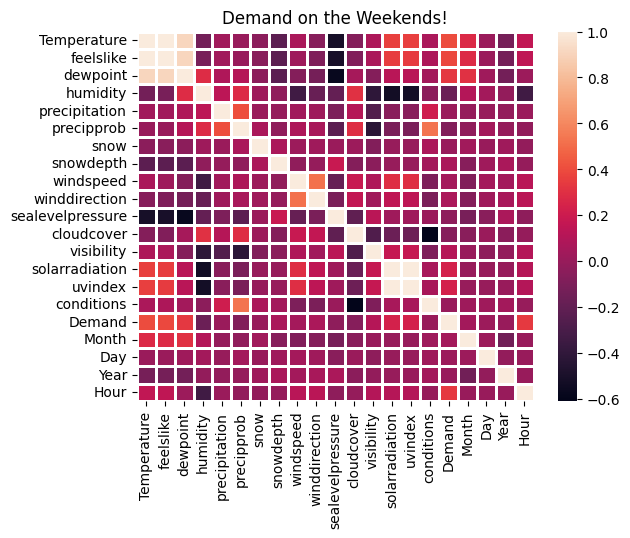

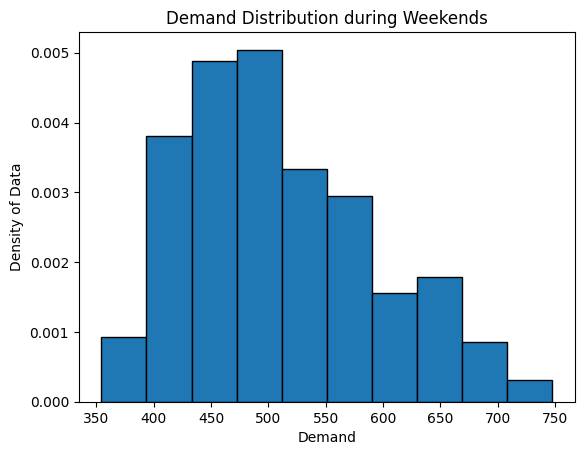

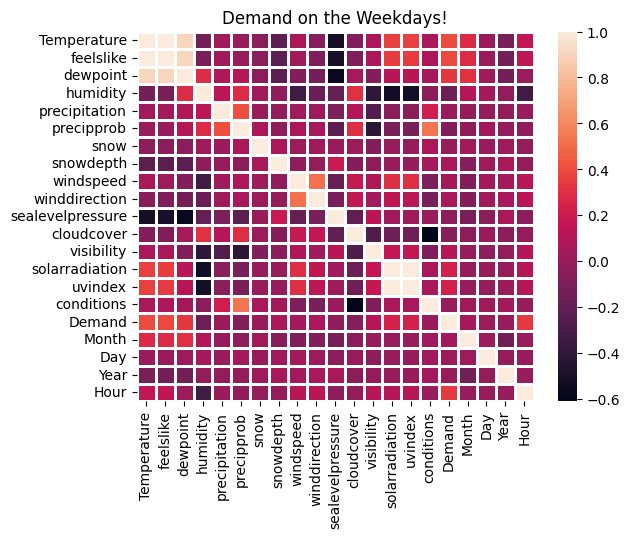

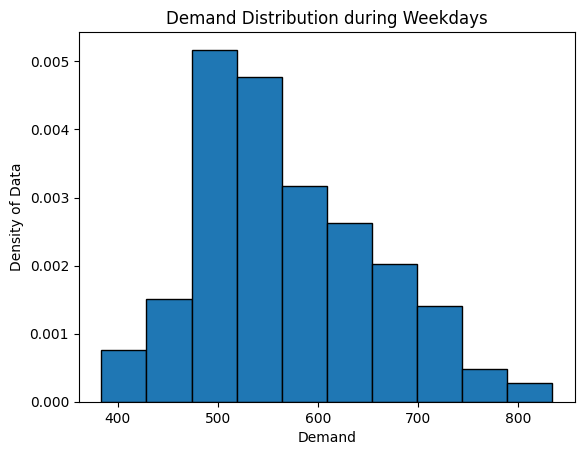

In [84]:
weekend_index = ['Sat', 'Sun']
days_name = ['Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue']
weekdays = ['Wed', 'Thur', 'Fri', 'Mon', 'Tue']
days_name_list = []

#There are 164 weeks for 1148 days
total_weeks = int((len(data_final))/(24*7))
#print (total_weeks)
for i in range(total_weeks):
    for j in range (7):
        for k in range (24):
            days_name_list.append(days_name[j])

data_final['DayName'] = days_name_list

df_weekends = data_final[data_final['DayName'].isin(['Sat', 'Sun'])]
df_weekdays = data_final[data_final['DayName'].isin(['Wed', 'Thur', 'Fri','Mon', 'Tue'])]
data_final = data_final.drop(columns=['DayName'])
df_weekends = df_weekends.drop(columns=['DayName'])
df_weekdays = df_weekdays.drop(columns=['DayName'])
weekends_corr = df_weekends.corr()
sns.heatmap(weekends_corr, linewidth = 1.0)
plt.title('Demand on the Weekends!')
plt.show()

demand_weekends = df_weekends['Demand']
demand_weekends_daily_average = np.array(demand_weekends).reshape(-1,24)
weekend_day_mean = []
for i in range(len(demand_weekends_daily_average)):
    weekend_day_mean.append(demand_weekends_daily_average[i].mean())
plt.hist(weekend_day_mean, edgecolor = 'black', density = True)
plt.title('Demand Distribution during Weekends')
plt.xlabel('Demand')
plt.ylabel('Density of Data')
plt.show()

weekdays_corr = df_weekdays.corr()
sns.heatmap(weekends_corr, linewidth = 1.0)
plt.title('Demand on the Weekdays!')
plt.show()

demand_weekends = df_weekdays['Demand']
demand_weekends_daily_average = np.array(demand_weekends).reshape(-1,24)
weekend_day_mean = []
for i in range(len(demand_weekends_daily_average)):
    weekend_day_mean.append(demand_weekends_daily_average[i].mean())
plt.hist(weekend_day_mean, edgecolor = 'black', density = True)
plt.title('Demand Distribution during Weekdays')
plt.xlabel('Demand')
plt.ylabel('Density of Data')
plt.show()

PRICE FORECASTING

In [49]:
start_value = 24
#select how many past hours are used to predict the next hour price. 

In [50]:
n_price_estimators = 100

df=pd.read_csv('.\Data\Price Forecasting\Prices.csv')
df = df[pd.notna(df['Prices\n(EUR/MWh)'])]
price_list = np.array(df['Prices\n(EUR/MWh)'])

train_list = []
predict_list = []
for i in range(len(price_list)-(start_value+1)):
    temp = price_list[i:i+start_value]
    temp_pred = price_list[i+start_value+1]
    train_list.append(temp)
    predict_list.append(temp_pred)
train_list = np.array(train_list).reshape(-1,start_value)
predict_list = np.array(predict_list).reshape(-1,1)

print (price_list.flatten(), predict_list.shape)


[26.38 26.5  27.01 ... 53.41 50.1  43.23] (34871, 1)


In [51]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=n_price_estimators)
model.fit(train_list, predict_list)

c:\Users\Dixant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [52]:
time_list = price_list.flatten().tolist()
time_list = time_list[-start_value:]

#In 7 days there are 168 hours so using 168 here
for i in range(168):
    time_list_latest = np.array(time_list[-start_value:]).reshape(-1,start_value)
    
    y_latest = model.predict(time_list_latest)
   
    time_list.append(y_latest[0])
print(len(time_list))


192


192


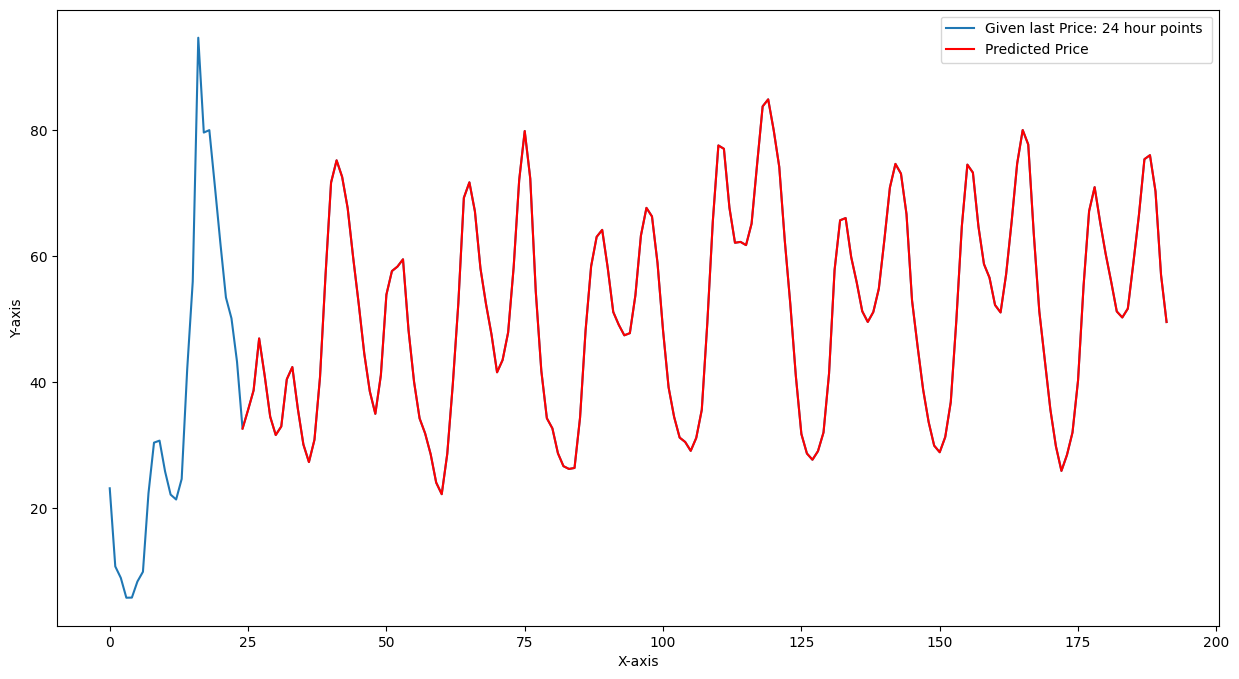

In [53]:
x = range(0, len(time_list))

y = time_list
print(len(y))
plt.figure(figsize = (15,8))
plt.plot(x, y, label=f'Given last Price: {start_value} hour points ')

start_point = start_value+1
end_point = len(time_list)

plt.plot(x[start_point-1:end_point], y[start_point-1:end_point], color='red', label='Predicted Price')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()
